In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/car_body_type_data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: stanford_cars_type/Hatchback/04498_Scion xD Hatchback 2012.jpg  
  inflating: stanford_cars_type/Hatchback/04503_Hyundai Veloster Hatchback 2012.jpg  
  inflating: stanford_cars_type/Hatchback/04514_Volkswagen Golf Hatchback 1991.jpg  
  inflating: stanford_cars_type/Hatchback/04526_Volkswagen Golf Hatchback 1991.jpg  
  inflating: stanford_cars_type/Hatchback/04528_Eagle Talon Hatchback 1998.jpg  
  inflating: stanford_cars_type/Hatchback/04530_Hyundai Elantra Touring Hatchback 2012.jpg  
  inflating: stanford_cars_type/Hatchback/04546_Volkswagen Beetle Hatchback 2012.jpg  
  inflating: stanford_cars_type/Hatchback/04582_Suzuki SX4 Hatchback 2012.jpg  
  inflating: stanford_cars_type/Hatchback/04587_Suzuki SX4 Hatchback 2012.jpg  
  inflating: stanford_cars_type/Hatchback/04599_Hyundai Veloster Hatchback 2012.jpg  
  inflating: stanford_cars_type/Hatchback/04600_Volkswagen Golf Hatchback 2012.jpg  
  inflating: stanford_c

In [ ]:
# Define paths
data_dir = '/content/stanford_cars_type'  # replace with your dataset path
train_data_dir = '/content/train'  # replace with your training data path
val_data_dir = '/content/validation'  # replace with your validation data path

# Create train and validation directories if not exist
os.makedirs(train_data_dir, exist_ok=True)
os.makedirs(val_data_dir, exist_ok=True)

# Get class directories
class_directories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# Split data into train and validation
for class_dir in class_directories:
    class_images = os.listdir(os.path.join(data_dir, class_dir))
    train_images, val_images = train_test_split(class_images, test_size=0.2, random_state=42)

    # Move images to respective directories
    for img in train_images:
        src_path = os.path.join(data_dir, class_dir, img)
        dest_path = os.path.join(train_data_dir, class_dir, img)
        os.makedirs(os.path.join(train_data_dir, class_dir), exist_ok=True)
        shutil.move(src_path, dest_path)

    for img in val_images:
        src_path = os.path.join(data_dir, class_dir, img)
        dest_path = os.path.join(val_data_dir, class_dir, img)
        os.makedirs(os.path.join(val_data_dir, class_dir), exist_ok=True)
        shutil.move(src_path, dest_path)

# Continue with the rest of the code (ImageDataGenerator and model training) from the previous example.


In [ ]:

# Define paths
train_data_dir = '/content/train'  # replace with your training data path
val_data_dir = '/content/validation'  # replace with your validation data path

# Set the image size and batch size
img_size = (224, 224)
batch_size = 16

# Create a data generator for validation
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse'
)


Found 1633 images belonging to 10 classes.


# The best Model yet

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse'
)

# Encode labels
label_encoder = LabelEncoder()
label_encoder.classes_ = train_generator.class_indices

# Load the pre-trained VGG16 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers up to a specific block
# Experiment with the value of `freeze_up_to` based on your dataset size and task
freeze_up_to = 17
for layer in base_model.layers[:freeze_up_to]:
    layer.trainable = False

# Create your model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu',kernel_regularizer='L2'),
    layers.Dropout(0.5),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Found 6511 images belonging to 10 classes.
80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Compile the model
#model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, epochs=100, validation_data=val_generator, callbacks=[early_stopping])

Epoch 1/100
407/407 [==============================] - 149s 330ms/step - loss: 4.1186 - accuracy: 0.3227 - val_loss: 3.0892 - val_accuracy: 0.4109
Epoch 2/100
407/407 [==============================] - 128s 315ms/step - loss: 2.4374 - accuracy: 0.5227 - val_loss: 2.0779 - val_accuracy: 0.5609
Epoch 3/100
407/407 [==============================] - 129s 316ms/step - loss: 1.8064 - accuracy: 0.6127 - val_loss: 1.5125 - val_accuracy: 0.6803
Epoch 4/100
407/407 [==============================] - 131s 321ms/step - loss: 1.4780 - accuracy: 0.6689 - val_loss: 1.3492 - val_accuracy: 0.6950
Epoch 5/100
407/407 [==============================] - 129s 317ms/step - loss: 1.2317 - accuracy: 0.7280 - val_loss: 1.2046 - val_accuracy: 0.7189
Epoch 6/100
407/407 [==============================] - 130s 319ms/step - loss: 1.0429 - accuracy: 0.7767 - val_loss: 1.2562 - val_accuracy: 0.6846
Epoch 7/100
407/407 [==============================] - 131s 322ms/step - loss: 0.9102 - accuracy: 0.8046 - val_loss: 1

Epoch 45/100\
407/407 [==============================] - 127s 313ms/step - loss: 0.0630 - accuracy: 0.9868 - val_loss: 0.6912 - val_accuracy: 0.8494
The best model yet

In [ ]:
model.save('VGG19_best_car_classification_model.h5')

# Save the label encoder for later use
import joblib
joblib.dump(label_encoder, 'label_encoder.pkl')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['label_encoder.pkl']

In [ ]:
import numpy as np


# Generate predictions for the validation set
val_predictions = model.predict(val_generator)

# Convert predictions to class labels
val_pred_labels = [np.argmax(pred) for pred in val_predictions]

# Get true labels from the generator
val_true_labels = val_generator.classes

103/103 [==============================] - 10s 100ms/step


In [ ]:
!pip install tensorflow scikit-learn seaborn

In [ ]:
class_labels = label_encoder.classes_

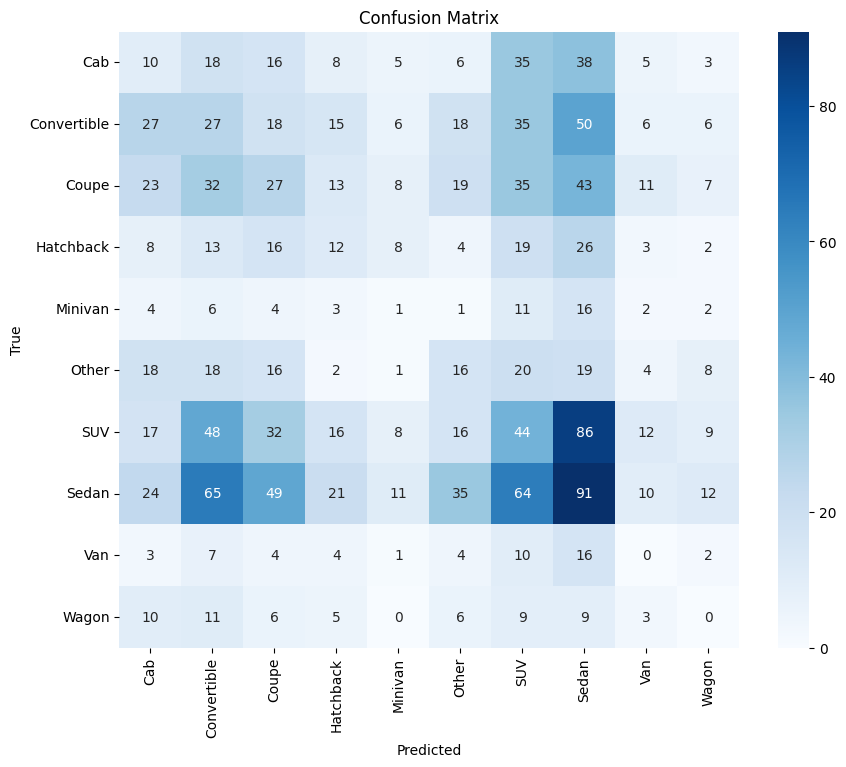

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
class_report = classification_report(val_true_labels, val_pred_labels, target_names=class_labels)

# Print the classification report
print(class_report)


              precision    recall  f1-score   support

         Cab       0.07      0.07      0.07       144
 Convertible       0.11      0.13      0.12       208
       Coupe       0.14      0.12      0.13       218
   Hatchback       0.12      0.11      0.11       111
     Minivan       0.02      0.02      0.02        50
       Other       0.13      0.13      0.13       122
         SUV       0.16      0.15      0.15       288
       Sedan       0.23      0.24      0.23       382
         Van       0.00      0.00      0.00        51
       Wagon       0.00      0.00      0.00        59

    accuracy                           0.14      1633
   macro avg       0.10      0.10      0.10      1633
weighted avg       0.14      0.14      0.14      1633



In [ ]:
model

In [ ]:
label_encoder.classes_

{'Cab': 0,
 'Convertible': 1,
 'Coupe': 2,
 'Hatchback': 3,
 'Minivan': 4,
 'Other': 5,
 'SUV': 6,
 'Sedan': 7,
 'Van': 8,
 'Wagon': 9}